# Laplacian Associative Memory (LAM) - DEV

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)

In [1]:
from nn import LAM

In [2]:
import itertools, PIL.Image, matplotlib, imageio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# np.random.seed(123)

---

#### LOAD IMAGE

In [4]:
FILENAME = "../data/images/kingfisher_resized.png"

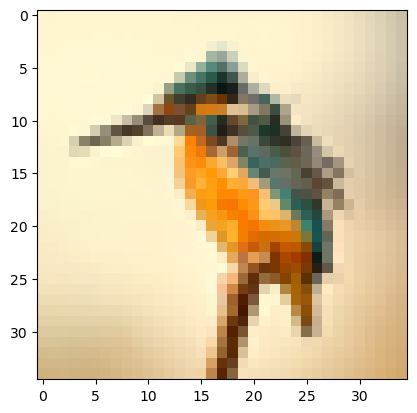

In [5]:
img = PIL.Image.open(FILENAME)
img = np.array(img, dtype=float) / np.max(img)
plt.imshow(img)

---

#### BUILD GRAPH

Each pixel is regarded as a node and link weights are determined by spatial proximity and similarity of RGB values.

In [6]:
n_row, n_col = img.shape[0], img.shape[1] # Input rows and columns
P = n_row * n_col # N_nodes

sigmaI = 0.1 # Intensity gaussian scale
sigmaX = 4.0 # Spatial gaussian scale
r = 5 # Search/boundary radius

# Build list of pixel relationships
tmp = itertools.product(range(n_row), range(n_col)) # All possible pairs of column and row indicies [0,0] ... [35,35]
combi_all = itertools.combinations(tmp, 2) # Take the indices and build a combination of pairs for comparing two locations against each other [(0,0), (0,1)] ... [(34,34), (34,34)])
combi = [x for x in combi_all if np.sqrt((x[0][0] - x[1][0])**2 + (x[0][1] - x[1][1])**2) < r] # Calculate the euclidian distance for each two-pair(x) and if the distance is below radius (r), add x to the list combi.

edgelist_w = [] # Malloc
for x1, x2 in combi:
    n1 = int(x1[0] * n_col + x1[1]) # Compute the flattened position on the grid for x1
    n2 = int(x2[0] * n_col + x2[1]) # Compute the flattened position on the grid for x2
    simval = np.exp(-np.sum((img[x1[0],x1[1]] - img[x2[0],x2[1]])**2) / (sigmaI**2)) * np.exp(-((x1[0]-x2[0])**2 + (x1[1]-x2[1])**2) / (sigmaX**2)) # Solve similarity link weights | Shi & Marik (2000) - The first term computes the intensity between pixels and the second term computes the spatial domain.
    edgelist_w.append((n1, n2, simval)) # Populate edgelist with neuron position (n1, n2) and simval

# Construct adjacency matrix, every symmetric node in the graph is equal to the corresponding simval
W = np.zeros([P, P])
for x in edgelist_w:
    W[x[0],x[1]] = x[2]
    W[x[1],x[0]] = x[2]

In [7]:
# Render euclidian distance map - taking each row of adjacency matrix an remapping back to resolution of source input
cmap = matplotlib.colormaps['magma']
frames = []
for i in range(P):
    if i%2==0:
        frame = W[i].reshape(n_row,n_col)
        frames.append(cmap(frame) * 255)

frames = np.uint8(frames)
imageio.mimsave('distMap.gif', frames)

Nnode= 1225 Nedge= 37010
169.05 point attactors
8882.40 bit capacity


Text(0.5, 1.0, 'Adjacency Weight Matrix')

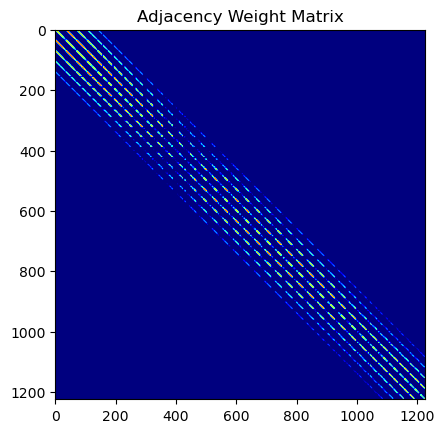

In [8]:
# Summary
print("Nnode=", P, "Nedge=", len(edgelist_w))
print(f"{P * 0.138:.2f} point attactors")
print(f"{0.24 * len(edgelist_w):.2f} bit capacity")

plt.imshow(W, cmap='jet')
plt.title('Adjacency Weight Matrix')

---

#### LAPLACIAN & EIGENVECTORS

Text(0.5, 1.0, 'Asymmetric')

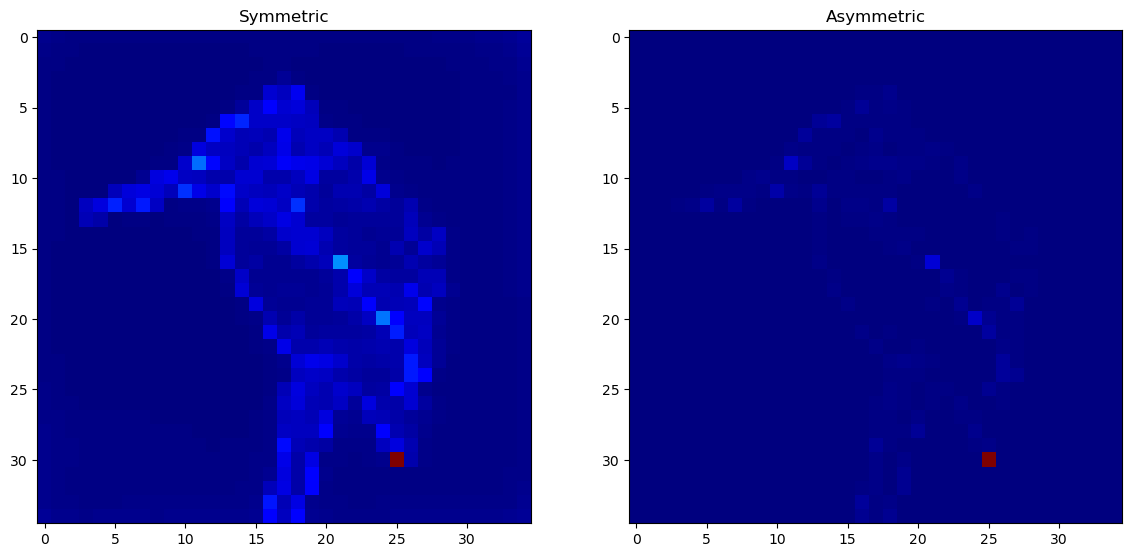

In [9]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
Dnorm_sym = np.diag(np.sum(W, axis=1)**-0.5) # SYMMETRIC normalized degree matrix
plt.imshow(np.sum(Dnorm_sym, axis=1).reshape(n_row,n_col), cmap='jet')
plt.title('Symmetric')

plt.subplot(1,2,2)
Dnorm_asym = np.diag(np.sum(W, axis=1)**-1) # ASYMMETRIC normalized degree matrix
plt.imshow(np.sum(Dnorm_asym, axis=1).reshape(n_row,n_col), cmap='jet')
plt.title('Asymmetric')

In [10]:
# Eigen Laplacian - ASYMMETRIC
L = np.eye(P) - Dnorm_asym @ W
e, v = np.linalg.eig(L)
e = np.real(e)
v = np.real(v)
order = np.argsort(e)
e = e[order]
v = v[:,order]

L | Min: -0.97 Max: 1.0


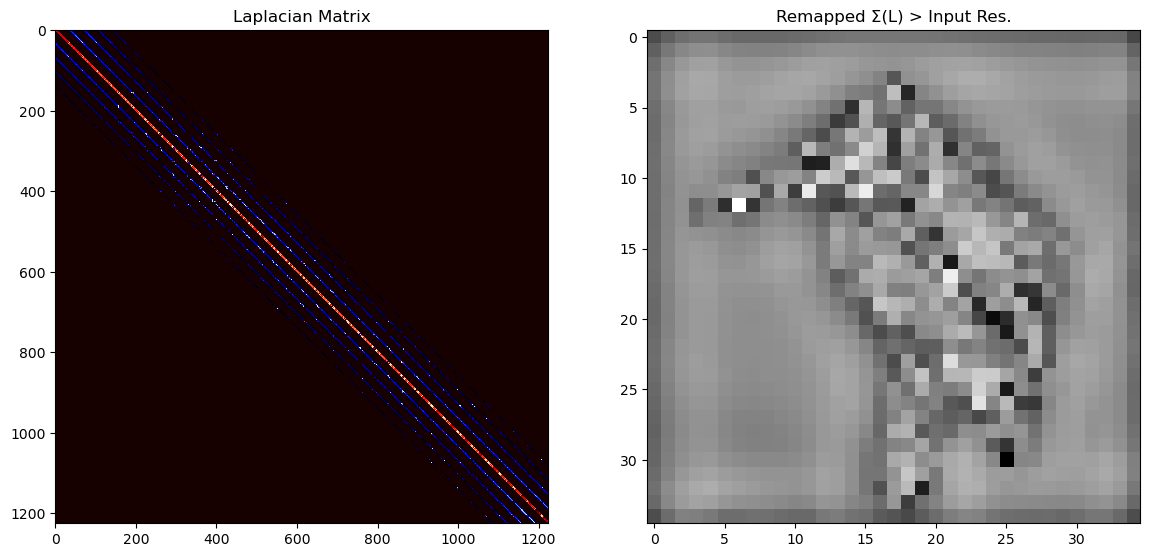

In [11]:
# Laplacian matrix
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(L, cmap='flag')
plt.title('Laplacian Matrix')

# Remapped sum of L matrix to input resolution
plt.subplot(1,2,2)
plt.imshow(np.sum(L, axis=0).reshape(n_row,n_col), cmap='binary')
plt.title('Remapped Σ(L) > Input Res.')

print('L | Min:', round(L.min(), 2), 'Max:', round(L.max(), 2))

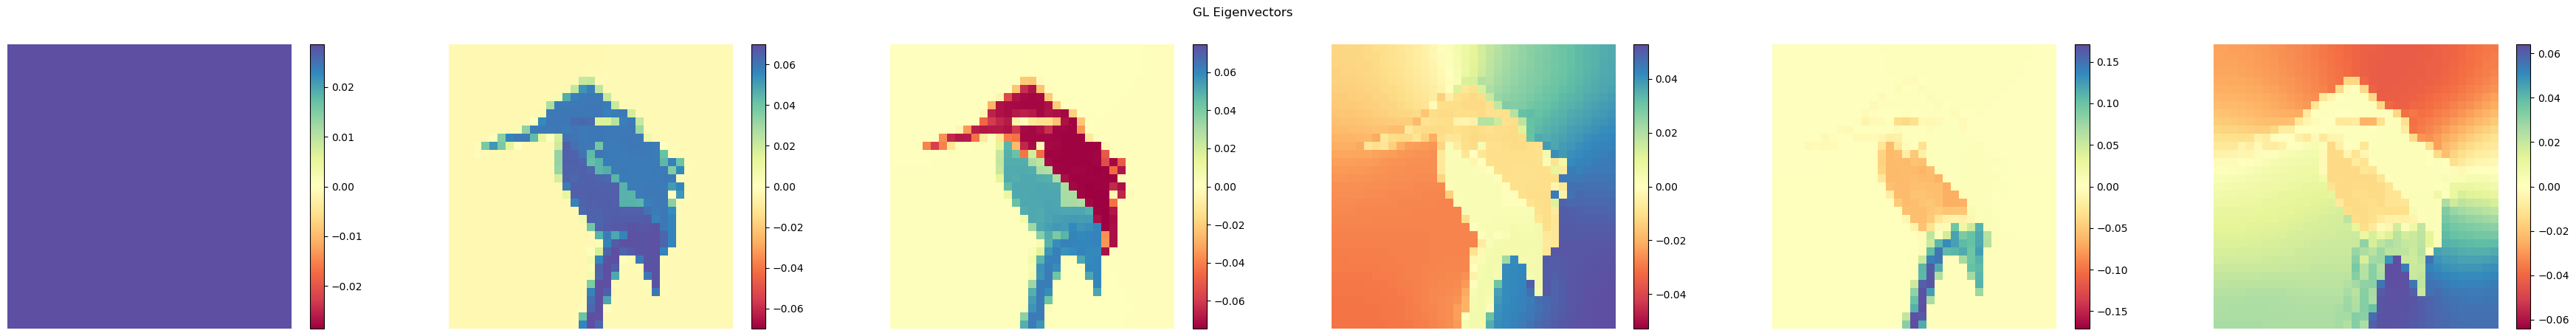

In [12]:
# Representative GL eigenvectors corresponding to segments obtained by LAM
plt.figure(figsize=(45,5))
plt.suptitle('GL Eigenvectors')
for k in range(6):
    color_max = np.max(np.abs(v[:,k]))
    plt.subplot(1, 6, k+1)
    plt.imshow(v[:,k].reshape((n_row,n_col)), cmap="Spectral", vmax=color_max, vmin=-color_max)
    plt.axis("off"), plt.colorbar()

---

#### COMPUTE GRAPH

In [13]:
N = 8192                                                         # Neurons | Default: 30000
prob = 0.1                                                       # Sparsity
eta = 0.01                                                       # Epsilon (?)
epochs = 3000                                                    # Steps
gamma = 0.6                                                      # Inhibition ratio
a_arr = np.arange(-1.5, 3.1, 0.1)                                # Alpha range

start_node = int(int(n_row/2) * n_col + int(n_row/2))            # Center cell of the grid
print(start_node)

# Malloc
a_hist, m_hist = [], []
obj_hist = np.zeros([len(a_arr), epochs])

612


In [14]:
graph = LAM(N, P, prob, W, gamma, "asym") # Build model

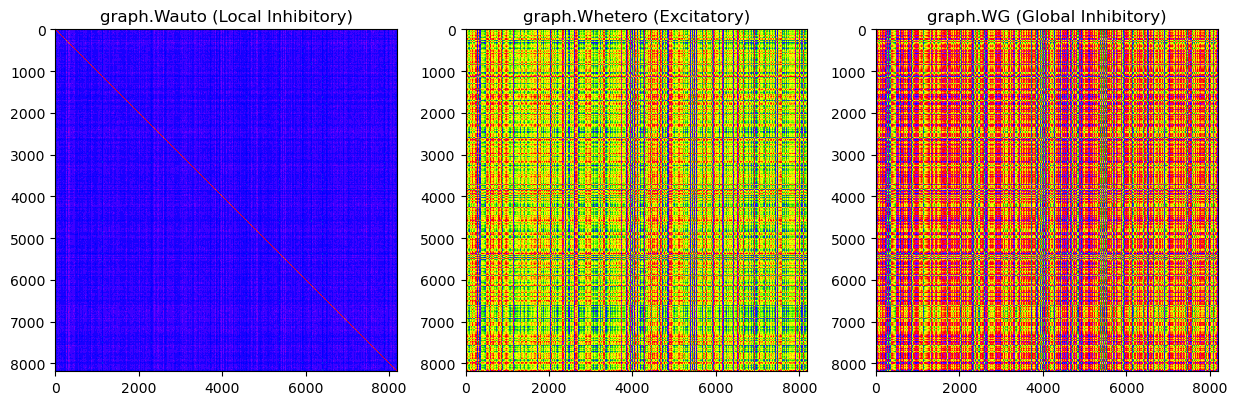

In [15]:
graph._set_weight(-0.9)
ticker = [graph.Wauto, graph.Whetero, graph.WG]
title = ['graph.Wauto (Local Inhibitory)', 'graph.Whetero (Excitatory)', 'graph.WG (Global Inhibitory)']

fig, axs = plt.subplots(1, len(ticker), figsize=(15,5))
for i in range(len(ticker)):
    axs[i].imshow(ticker[i], cmap='prism')
    axs[i].set_title(title[i])

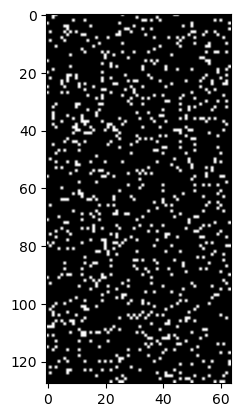

In [16]:
tmp_x = graph.xi[:, start_node].copy()
plt.imshow(tmp_x.reshape(128,64), cmap='gray')

In [17]:
# Test simulation
# m_log, obj_log = graph.simulate_single(-0.9, eta, epochs, start_node) # Simulate alpha
# m = m_log[-1,:]

# color_max = np.max(np.abs(m))
# plt.imshow(m.reshape((n_row,n_col)), cmap="Spectral", vmax=color_max, vmin=-color_max)

In [18]:
# Z6 - 20 Cores @ 2.2Ghz

# 2048 = 8min
# 8192 = 45mins
# 30000 = ??

for a_ind in tqdm(range(len(a_arr))):
    a = np.around(a_arr[a_ind], decimals=1) # Isolate (a) from array
    m_log, obj_log = graph.simulate_single(a, eta, epochs, start_node) # Simulate alpha
    m = m_log[-1,:] # Extract final row (epoch) from m_log

    # Append callbacks
    a_hist.append(a)
    m_hist.append(m)
    obj_hist[a_ind,:] = obj_log

100%|██████████| 46/46 [47:04<00:00, 61.40s/it]


(8192, 1225)


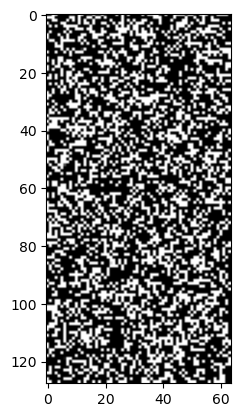

In [19]:
print(graph.xi.shape)
plt.imshow(graph.x.reshape(128,64), cmap='gray')

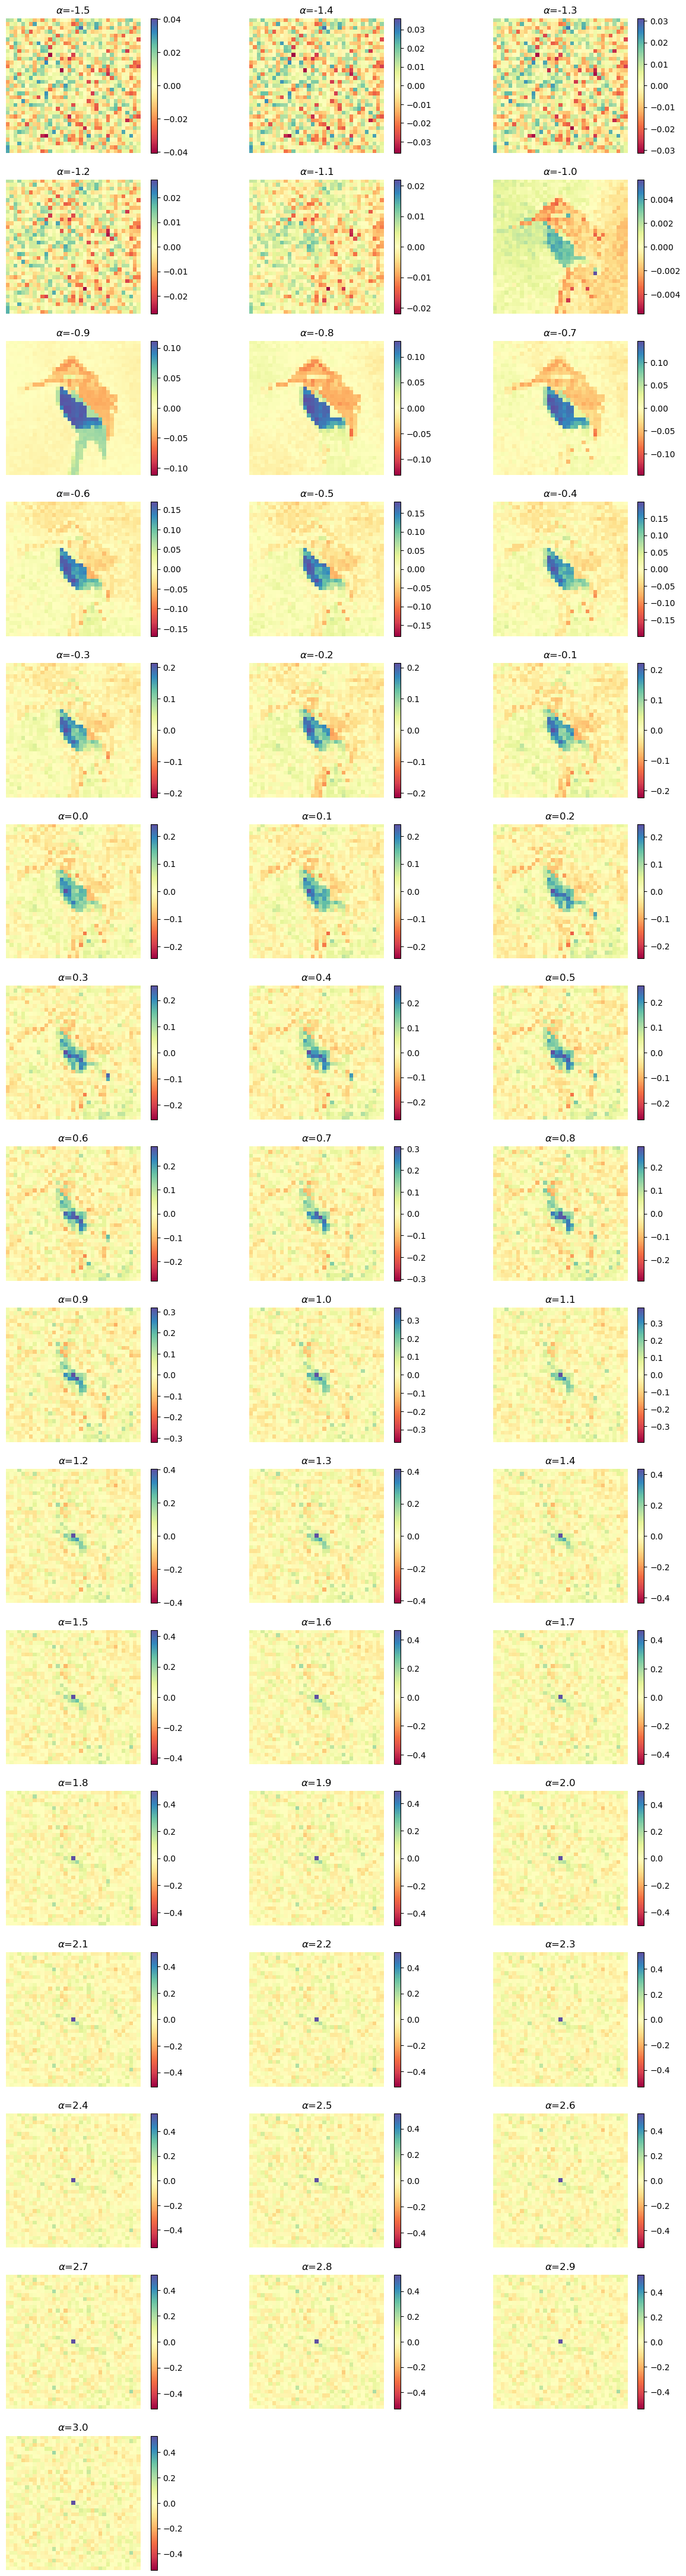

In [20]:
# Pattern overlaps obtained after the simulation of LAM at different *α* values
plt.figure(figsize=(15,70))
for a_ind in range(len(a_arr)):
    a = np.around(a_arr[a_ind], decimals=1)
    m = m_hist[a_ind]
    color_max = np.max(np.abs(m))

    plt.subplot(20, 3, a_ind+1)
    plt.imshow(m.reshape((n_row,n_col)), cmap="Spectral", vmax=color_max, vmin=-color_max)
    plt.axis("off"), plt.colorbar()
    plt.title(r"$\alpha$="+str(a))

---

#### PLOT STATISTICS

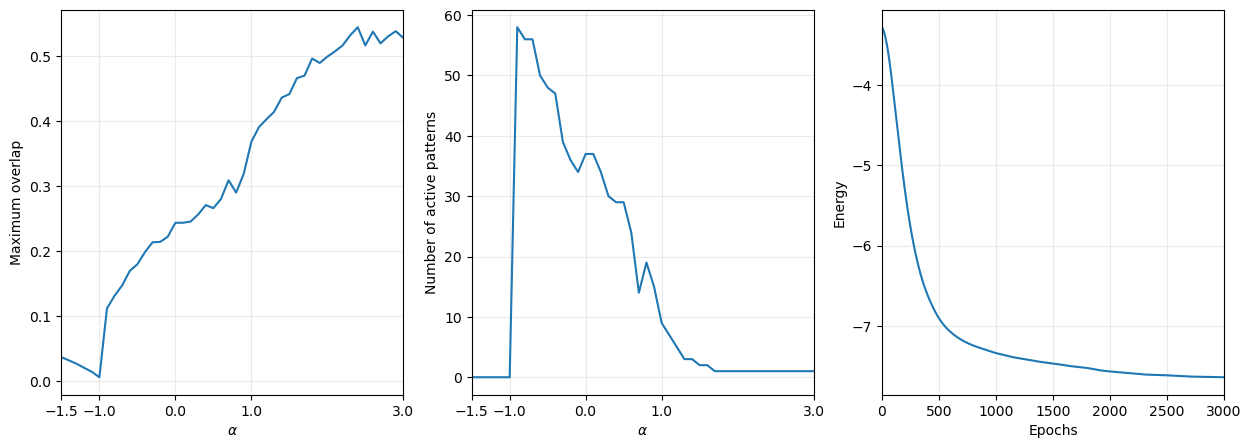

In [21]:
Na = len(a_arr)
max_overlap = np.zeros(Na)
Nactive = np.zeros(Na)

for a_ind in range(Na):
    m = m_hist[a_ind]
    max_m = np.max(m)
    max_overlap[a_ind] = max_m
    Nactive[a_ind] = np.mean(np.sum((m > 0.5*max_m) * (m > 0.05), axis=0))

xlim=[np.min(a_arr), np.max(a_arr)]
xticks=[xlim[0], -1, 0, 1, xlim[1]]

# Max. overlap
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(a_arr, max_overlap)
plt.xlabel(r"$\alpha$"), plt.ylabel("Maximum overlap")
plt.xlim(xlim), plt.xticks(xticks)
plt.grid('on', alpha=0.25)

# Number of patterns
plt.subplot(1,3,2)
plt.plot(a_arr, Nactive)
plt.xlabel(r"$\alpha$"), plt.ylabel("Number of active patterns")
plt.xlim(xlim), plt.xticks(xticks)
plt.grid('on', alpha=0.25)

# Energy
plt.subplot(1,3,3)
plt.plot(obj_log)
plt.xlabel("Epochs"), plt.ylabel("Energy")
plt.xlim(0,epochs)
plt.grid('on', alpha=0.25)

---

#### EXPLAINED VARIANCE

The explained variance ratio in linear regressions of pattern overlaps by various numbers of GL eigenvectors. Colour indicates value of *α*.

(<matplotlib.legend.Legend at 0x7fe3d20dc910>, None)

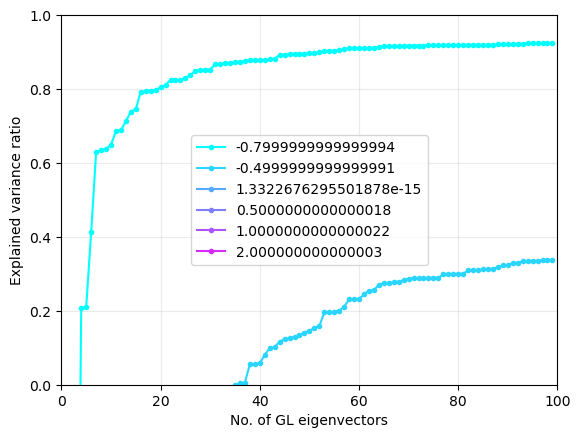

In [22]:
val_ind_pick = [7, 10, 15, 20, 25, 35]
val_arr = [a_arr[i] for i in val_ind_pick]
val_hist = [m_hist[i] for i in val_ind_pick]

p = 100
Rsquare = np.zeros([len(val_arr),p])

# EXPLAINED VAR (GL AND ATTRACTOR)
for val_ind in range(len(val_arr)):
    var = np.var(m_hist[val_ind])
    for i in range(p):
        coeff, res, rank, sing = np.linalg.lstsq(v[:,:i+1], val_hist[val_ind], rcond=None)
        Rsquare[val_ind,i] = 1-np.mean(res) / v.shape[0]/var

# SIMILARITY (OVERLAP AND BASES)
cm = plt.get_cmap("cool")
for i in range(len(val_arr)):
    plt.plot(Rsquare[i,:], ".-", label=str(val_arr[i]), color=cm(i/len(val_arr)))

plt.xlim([0,p]), plt.ylim([0,1])
plt.xlabel("No. of GL eigenvectors")
plt.ylabel("Explained variance ratio")
plt.legend(), plt.grid('on', alpha=0.25)